In [9]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split


df = pd.read_csv('data/train.csv')

X_train, X_test, y_train, y_test = train_test_split(df.text,df.target,test_size=0.3,random_state=42, shuffle=True)

X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]


(5329, 2284, 5329, 2284)

In [10]:
# one_hot_encoded_df= pd.read_csv('data/one_hot_encoded_df.csv')

In [11]:
import numpy as np
import pandas as pd

# Assuming df is your DataFrame containing the tweets
# Create the vocabulary

vocabulary = np.array([])
for i in range(len(df.index)):
    words = df['text'].iloc[i].split()  
    vocabulary = np.append(vocabulary, np.unique(words))  
    vocabulary = np.unique(vocabulary)

# Create a dictionary to map each word to an index
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

# Function to one-hot encode a tweet
def one_hot_encode(tweet, vocab_size):
    one_hot_vector = np.zeros(vocab_size)
    for word in tweet.split():
        if word in word_to_index:
            index = word_to_index[word]
            one_hot_vector[index] = 1
    return one_hot_vector

# Apply the one-hot encoding to each tweet
one_hot_encoded_tweets = np.array([one_hot_encode(tweet, len(vocabulary)) for tweet in df['text']])

# Convert to DataFrame for better readability (optional)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_tweets, columns=vocabulary)
print(one_hot_encoded_df.columns)

Index(['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!!!!!!#MetroFmTalk', '!The',
       '#', '##book', '##fukushima',
       ...
       'å£9!', 'å¤}', 'å¨', 'å©Daniel', 'å¬'Only', 'åÇ', 'åÈ',
       'åÈMGN-AFRICAå¨', 'åÊ', 'åÊFedEx'],
      dtype='object', length=31924)


In [12]:
n_letters = one_hot_encoded_df.shape[1]
n_letters

31924

In [13]:
def letterToIndex(letter):
    return one_hot_encoded_df.columns.get_loc(letter)

def lineToTensor(line):
    line = line.split()
    # We want to have a tensor that, in the first dimension has the sequence index
    # 2nd dimension idk
    # 3d dimension for the one hot element

    # Create empty tensor
    tensor = torch.zeros(len(line), 1, n_letters)

    # Create the sequence tensor
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1

    return tensor


def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden  = 128
n_letters = 31924
n_categories = 2

rnn = RNN(n_letters, n_hidden, n_categories)

In [15]:
all_categories = [1,0]

In [16]:
import torch.optim as optim
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.train()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()



In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    # Choose a line randomly
    line = randomChoice(X_train[y_train==category].index)
    # Convert to tensor
    line_tensor = lineToTensor(df.text.iloc[line])

    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    
    return category, line, category_tensor, line_tensor

randomChoice(all_categories)

randomChoice(X_train[y_train==1].index)

randomTrainingExample()

(1,
 4075,
 tensor([0]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]]))

In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plottingtest
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (12m 47s) 0.6049 6996 / 0 ✓
10000 10% (26m 29s) 0.0710 581 / 1 ✓
15000 15% (39m 53s) 0.8372 2601 / 0 ✗ (1)
20000 20% (54m 25s) 1.5659 6067 / 0 ✗ (1)
25000 25% (69m 12s) 0.2572 1774 / 1 ✓
30000 30% (84m 40s) 0.0484 2390 / 1 ✓
35000 35% (99m 5s) 0.9242 4193 / 1 ✗ (0)
40000 40% (113m 18s) 0.1770 967 / 0 ✓
45000 45% (128m 59s) 0.9250 6165 / 1 ✗ (0)
50000 50% (145m 5s) 1.4978 5069 / 0 ✗ (1)
55000 55% (160m 4s) 0.5208 6441 / 1 ✓
60000 60% (174m 58s) 0.8480 2754 / 0 ✗ (1)
65000 65% (190m 6s) 1.9855 4951 / 1 ✗ (0)
70000 70% (204m 59s) 1.8211 4038 / 1 ✗ (0)
75000 75% (219m 49s) 0.4143 3775 / 0 ✓
80000 80% (234m 35s) 0.9087 5716 / 0 ✗ (1)
85000 85% (249m 33s) 3.3461 1445 / 1 ✗ (0)
90000 90% (264m 38s) 1.7300 3339 / 0 ✗ (1)
95000 95% (280m 37s) 1.2413 3271 / 0 ✗ (1)
100000 100% (296m 44s) 0.1406 6944 / 1 ✓


In [22]:
category, line, category_tensor, line_tensor = randomTrainingExample()

(tensor([[-2.8604, -0.0589]], grad_fn=<LogSoftmaxBackward0>),
 2.8604416847229004)

In [36]:
torch.save(rnn, 'rnn1.pth')

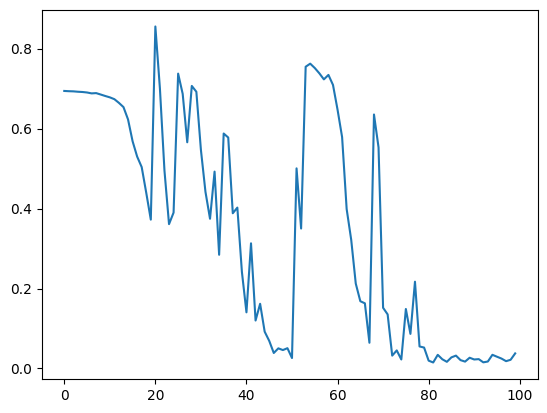

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)